# Supplemental Figure 9 — Validation of retron-based editing using a single substitution retron.


This notebook reproduces **Figure S9** from the supplemental manuscript.

---

### Figure Summary

<div style="text-indent:-2em; padding-left:2em"><strong>(A)</strong> Plaque assay data of sequenced phage pool data from retron editing in Figure 5B with an additional control.</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(B)</strong> Phage pool data of all pools from A.</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(C)</strong> Nanopore data of a single retron edit location.</div>  

## Notebook Setup
----------------------------

Run the following cell to import all required libraries, define plotting settings, and configure the environment for data analysis and visualization.

In [ ]:
# --- Import necessary modules ---
import os
import sys
os.chdir("..")
import json
import pickle as pkl
from importlib import reload
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import scipy
from Bio import SeqIO
import csv
from Bio.SeqIO import QualityIO
from utils import dna_rev_comp, translate_dna2aa
from scripts.preprocessing_functions import *
from scripts.plotting import *
from scripts.Nanopore_functions import *
from scripts.Illumina_functions import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# ======================== PLOTTING SETTINGS ========================

# --- Custom color map for mutation visualization ---
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
], N=256)

# --- Seaborn theme configuration ---
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1
}
sns.set_theme(context="paper", style='ticks', palette="Greys_r", rc=custom_params)

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})

# ======================== LAYOUT PARAMETERS ========================

# --- Pre-defined figure dimensions for multi-panel plots ---
hi = 10.5 * 0.75
wi3 = 2.24
wi2 = 4.76
wi1 = 7.24
nr = 5

# --- Utility for shortening sample names ---
short_fn = np.vectorize(lambda x: x[:5])

## Figure S9A: Plaque assay data of sequenced phage pool data from retron editing in Figure 5B with an additional control.
----------------------------

Plaque assay comparing editing outcomes from different retron configurations. Conditions include: a non-targeting retron with active reverse transcriptase (RT); a targeting retron with no edit (active RT); a targeting retron encoding an A-to-G substitution with a catalytically inactive RT; and a targeting retron with the A-to-G substitution and active RT. Plaque output was assessed after infection and induction with aTc and IPTG.

![Alt Text](/Volumes/ag-niopek/Niopek_Lab/8_Data/1_Nanopore/DMS_analysis/figure_notebooks/figure_illustrations/Figure_S9A.png)

## Figure S9B: Phage pool data of all pools from A.
----------------------------
Sanger sequencing chromatograms of phage pools from each aTc-induced condition in panel A. Efficient editing was observed only in the presence of an active RT and an on-target edit, resulting in a fully converted allele with no detectable wild-type sequence. 


Chromatograms were generated from `.ab1` sequencing files using the Python script `scripts/impose_enrichment_on_pymol.py`, which overlays base signal intensities across aligned reads. Final figure layout and annotations were created in Adobe Illustrator.

![Alt Text](/Volumes/ag-niopek/Niopek_Lab/8_Data/1_Nanopore/DMS_analysis/figure_notebooks/figure_illustrations/Figure_S9B.png)

## Figure S9C:  Nanopore data of a single retron edit location.
----------------------------
Nanopore sequencing of phage populations edited using a retron encoding a G-to-T substitution. A 71% editing rate was achieved using a high-titer input of 1010 pfu/mL. Reference and mutant codons are shown along the sequence per position.


The data underlying this visualization was generated from preprocessed reads. Initial processing steps—including quality filtering, alignment, and correction of frame-disrupting indels introduced by Nanopore sequencing errors—were carried out using the scripts `Nanopore_read_filtering.py`, `Nanopore_alignment.py`, and `Nanopore_quality_control.py`. Alternatively, the complete workflow can be executed via the shell script `Nanopore_filtering_alignment_processing.sh`, which sequentially integrates all these steps.

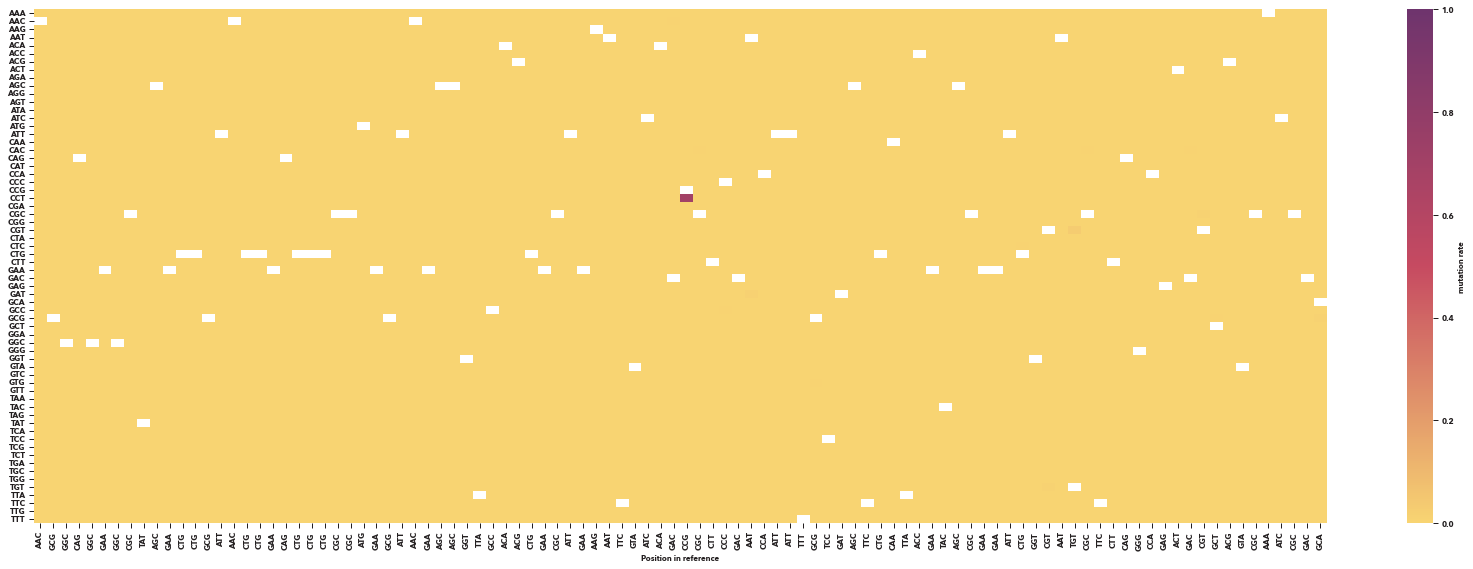

In [4]:
# --- Define parameters and file paths ---
data_folder = "Nanopore_P0115"
barcode = "barcode24"
quality = 20
data_type = "Codons"
FigFolder = f"final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/"

# --- Load mutation data files ---
all_variants = pd.read_csv(f"final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/all_variants_{data_type}.csv", index_col = 0)
enrichment_relative = pd.read_csv(f"final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_{data_type}.csv", index_col = 0)
enrichment_counts = pd.read_csv(f"final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_counts_{data_type}.csv", index_col = 0)
araclov2_enr = pd.read_csv(f"final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)


# --- Identify maximum enrichment value ---
# (This value gives an idea of the highest observed mutation rate)
araclov2_enr.max().max()

# --- Preprocess enrichment data ---
# Remove "X" row (e.g. deletions or padding) and the final incomplete codon column
araclov2_enr = araclov2_enr.iloc[:-1,:] ## we exclude the "X" column (triplets with "-") and the last "T" column for this, which is the last nt of the ref that is not a triplet

# --- Define region around the highest enrichment point for visualization ---
enr_roi = np.where(araclov2_enr ==araclov2_enr.max().max())[1][0]
araclov2_enr_roi = araclov2_enr.iloc[:,enr_roi-50: enr_roi+50]


# Strip numeric suffix from codon column labels (keep only base identities)
araclov2_enr_roi.columns = araclov2_enr_roi.columns.str.replace(r'\d+', '', regex=True)

# --- Define custom colormap for enrichment heatmap ---
enrichment_cmap = LinearSegmentedColormap.from_list("enrichment_cmap", [
    "#F8D472", 
    '#C64A61',  
    '#6E346D', 
], N=256)

# --- Plot enrichment heatmap ---
plt.figure(figsize = (wi1*4,hi*1.2))
sns.heatmap(araclov2_enr_roi, cmap = enrichment_cmap, xticklabels = True, yticklabels=True, vmax = 1.0, cbar_kws = {"label":"mutation rate"})
plt.xlabel("Position in reference")
plt.show()
# plt.savefig(f"{FigFolder}/mutation_enrichment.pdf", bbox_inches = "tight", dpi = 600)
# plt.savefig(f"{FigFolder}/mutation_enrichment.png", bbox_inches = "tight", dpi = 600)